In [4]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
from jupyterthemes import jtplot
jtplot.style()


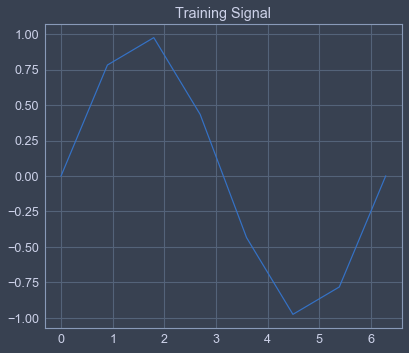

In [7]:
'''Generate input data'''
k = 8 # Number of Observations
n = 100  #umber of testing inputs
eps = 1.49e-08 # really small jitter for numerical stability

# Noiseless training data
Xtrain = np.linspace(start=0, stop=2*math.pi, num=k) [:,np.newaxis] # Training Inputs
ytrain = np.sin(Xtrain)  # Training targets

fig,ax = plt.subplots()
plt.plot(Xtrain,ytrain)
plt.title('Training Signal')
plt.show()

Xtest = np.linspace(-0.5,2*math.pi+0.5,n)[:,np.newaxis]

In [8]:
# Define the kernel function

def Square_Euclidean_Distance_Matrix(X1,X2):
    n = X1.shape[0]
    m = X2.shape[0]
    
    if X1.shape[1] == 1: # vectors
        r1 = X1.reshape(n,1) * np.ones([1,m])
        r2 = X2.reshape(1,m) * np.ones([n,1])
        sed = ((r1 - r2) ** 2)
    elif X1.shape[1] == 2: # matrices for 2D feature space
        r1x = X1[:,0].reshape(n,1) * np.ones([1,m])
        r1y = X1[:,1].reshape(n,1) * np.ones([1,m])
        r2x = X2[:,0].reshape(1,m) * np.ones([n,1])
        r2y = X2[:,1].reshape(1,m) * np.ones([n,1])
        sed = ((r1x - r2x) ** 2 + (r1y - r2y) ** 2)
    else: 
        print("too many dimensions in X matrices", X1.shape)
        return None
    return sed


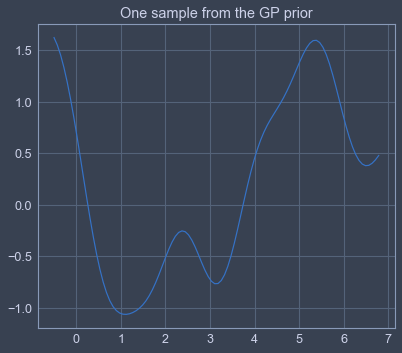

In [11]:
np.random.seed(1) #set seed for consistency

DXtest = Square_Euclidean_Distance_Matrix(Xtest,Xtest)
K_ss = np.exp(-DXtest) # Auto-correlation between test points K(X*,X*)

# Get the lower cholesky factor of the covariance matrix
L = np.linalg.cholesky(K_ss+eps*np.eye(n))

# make 1 draw
f_prior1 = np.dot(L, np.random.normal(size=(n,1)))

# Plotting the drawn prior
fig,ax = plt.subplots()
plt.plot(Xtest,f_prior1)
plt.title('One sample from the GP prior')
plt.show()
fig.savefig('Figures/1Draw.png', bbox_inches='tight')

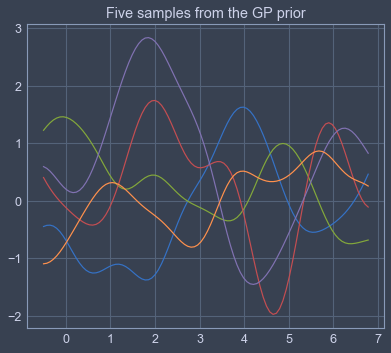

In [12]:
# Make 5 draws
f_prior5 = np.dot(L, np.random.normal(size=(n,5)))

# Plotting all 5 priors
fig,ax = plt.subplots()
plt.plot(Xtest,f_prior5)
plt.title('Five samples from the GP prior')
plt.show()
fig.savefig('Figures/5Draw.png', bbox_inches='tight')

Text(0.5,1,'$K(X,X)$')

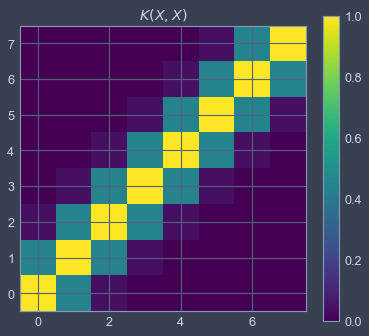

In [16]:
'''Now, let us make a posterior for 100 samples that 
were not used previously for training the GP'''

# Generate all necessary kernels for predictions
D = Square_Euclidean_Distance_Matrix(Xtrain,Xtrain) #Sqaured Euclidean Distance
K = np.exp(-D + np.diag(eps*np.ones(k))) # K(X,X)
fig,ax = plt.subplots()
plt.imshow(K)
ax.set_ylim(ax.get_ylim()[::-1])
plt.colorbar()
plt.title(u'$K(X,X)$')

Text(0.5,1,'$K(X^*,X^*)$')

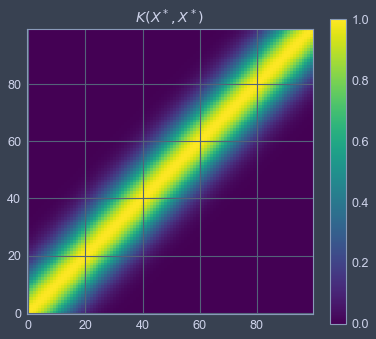

In [17]:
nfig,ax = plt.subplots()
plt.imshow(K_ss)
ax.set_ylim(ax.get_ylim()[::-1])
plt.colorbar()
plt.title(u'$K(X^*,X^*)$')

Text(0.5,1,'$K(X,X*)$')

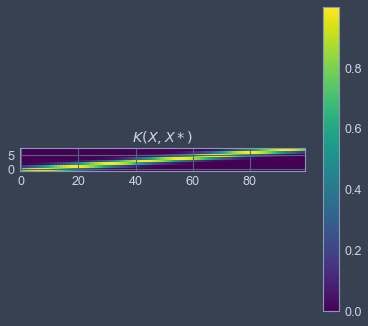

In [44]:
# Apply the kernel function to our training points
L = np.linalg.cholesky(K) # lower cholesky factor

# Compute the mean at our test points
DX = Square_Euclidean_Distance_Matrix(Xtrain,Xtest)
K_s = np.exp(-DX) # Cross Correlation between test and train inputs
fig,ax = plt.subplots()
plt.imshow(K_s)
ax.set_ylim(ax.get_ylim()[::-1])
plt.colorbar()
plt.title(u'$K(X,X*)$')

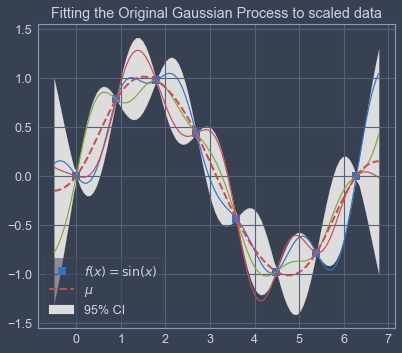

In [45]:
Lk = np.linalg.solve(L, K_s)
mu = np.dot(Lk.T, np.linalg.solve(L,ytrain)).reshape((n,))

# Compute the standard deviation to find the Upper and Lower Quantiles
s2 = np.diag(K_ss) - np.sum(Lk**2,axis=0) # variance
stdv = np.sqrt(s2) #standard deviation

# Draw samples from the posterior at the test points
L = np.linalg.cholesky(K_ss+eps*np.eye(n) - np.dot(Lk.T,Lk)) # add small jitter to keep the kernel psd
f_post = mu.reshape(-1,1) + np.dot(L,np.random.normal(size=(n,3)))

# Generate Plots
fig,ax = plt.subplots()
plt.plot(Xtrain,ytrain,'bs',ms=8,label=u'$f(x) = \sin(x)$') # Original Data
plt.plot(Xtest,f_post) # Posterior Samples
plt.gca().fill_between(Xtest.flat, mu-2*stdv,mu+2*stdv, color="#dddddd", label='95% CI') # A 95% confidence interval is used\
plt.plot(Xtest,mu,'r--',lw=2,label=u'$\mu$') #Posterior mean
ax.legend(loc='best', fancybox=True,framealpha=0.5)
plt.title('Fitting the Original Gaussian Process to scaled data')
plt.show()
